# Digitally Adjustable Power Supply
DC/DC : LM2576

![Schematic Feedback](img/smps_feedback.drawio.png)

$I_1+I_3=I_2$

$I_2=\frac{U_2}{R_2}=\frac{V_{REF}}{R_2}$

$U_{1}=V_{OUT}-V_{REF}$

$I_1=\frac{U_{1}}{R_1}=\frac{V_{OUT}-V_{REF}}{R_1}$

$I_3=\frac{U_{3}}{R_3}=\frac{V_{DAC}-V_{REF}}{R_3}$


$\frac{V_{OUT}-V_{REF}}{R_1}+\frac{V_{DAC}-V_{REF}}{R_3}=\frac{V_{REF}}{R_2}$



LM2576 Datasheet :

$V_{REF}=1.23V$ and $1k\Omega<R_2<5k\Omega$


## Requirements installation

In [ ]:
!pip install simpy eseries numpy matplotlib

## Resistors Exx Series between $1k\Omega$ and $5k\Omega$

Resistor serie can be chosen with `SERIE` variable.

In [53]:
from eseries import erange, E12, E24, E48, E96, E192

SERIE = E24

res_list = erange(SERIE, 1000, 5000)

print(list_res)

[1100, 1200, 1300, 1500, 1600, 1800, 2000, 2200, 2400, 2600, 2900, 3200, 3500, 3800, 4200, 4600, 5100]


## Initial conditions of the equation system

Goal : R1 and R3 calculation with a given $V_{DAC}$ and $V_{OUT}$ values

| $V_{DAC}$ | $V_{OUT}$ |
|-----------|-----------|
| 0 V       | 19 V       |
| 3.3 V     | 1 V      |

In [54]:
from sympy import symbols, Eq, solve
from eseries import find_nearest, E12, E24, E48, E96, E192

VREF = 1.23
VDAC_1 = 0.0
VDAC_2 = 3.3
VOUT_1 = 18.0
VOUT_2 = 1.0
R2 = 1000


## Solve R1 and R3 values

In [55]:
R1, R3 = symbols('R1 R3')
eq1 = Eq((VOUT_1 - VREF) / R1 + (VDAC_1 - VREF) / R3, VREF / R2)
eq2 = Eq((VOUT_2 - VREF) / R1 + (VDAC_2 - VREF) / R3, VREF / R2)
sol = solve((eq1, eq2), (R1, R3), dict=True)
print("R1 = ", sol[0][R1])
print("R3 = ", sol[0][R3])

R1_real = find_nearest(SERIE, sol[0][R1])
R3_real = find_nearest(SERIE, sol[0][R3])
print("R1 Real = ", R1_real)
print("R3 Real = ", R3_real)

R1 =  8482.63118994826
R3 =  1646.62840746055
R1 Real =  8200.0
R3 Real =  1600.0


## Real $V_{OUT}$ values

$\frac{V_{OUT}-V_{REF}}{R_1}+\frac{V_{DAC}-V_{REF}}{R_3}=\frac{V_{REF}}{R_2}$

$V_{OUT}=V_{REF}+\frac{V_{REF}}{R_2}R_1+\frac{V_{REF}-V_{DAC}}{R_3}R_1$



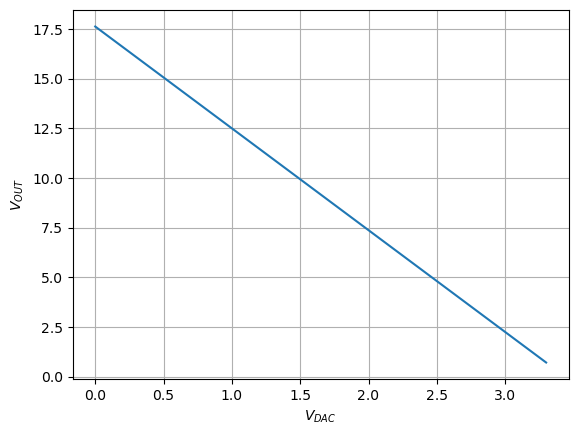

For VDAC = 0.0 V, VOUT = 17.61975 V
For VDAC = 3.3 V, VOUT = 0.7072500000000002 V


In [58]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(VDAC_1, VDAC_2, 100)
y = VREF + (VREF * R1_real / R2) + ((VREF - x) * R1_real / R3_real)
plt.plot(x, y)
plt.grid()
plt.xlabel('$V_{DAC}$')
plt.ylabel('$V_{OUT}$')
plt.show()

print("For VDAC =", x[0], "V, VOUT =", y[0], "V")
print("For VDAC =", x[-1], "V, VOUT =", y[-1], "V")
